# Wrangling

## Download the Data and Wrangle It
* The adoption data comes freely available from the Austin Animal Center (AAC) shelter via the Socrata Open Data API (SODA).  It is divided into two sets based upon the intake of the animals and when the animals left the shelter.  This is a no kill shelter thus outcomes are either adoption, transfer to a rescue, or return to owner.
    * [AAC intakes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm)
    * [AAC outcomes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)
    
* I have chosen to use pandas dataframes to store and manipulate the data.
* The API gives the choice of downloading the data in CSV or JSON format.
    * The CSV format of the files will be downloaded.
    
* For continuity and the sake of time, I will only focus on the dog adoptions as the images later or only of dogs.


In [1]:
#import necessary packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from datetime import datetime
from collections import defaultdict

#set max rows of pandas to display to 1000
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

#install sodapy a specific python package for working with the API.
!pip install sodapy
from sodapy import Socrata #specific python package for working with the API.

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### A) Intake Data

In [2]:
#now let's download the intake data
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.austintexas.gov", None)

# First 100000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
#right now the data base says it contains 84903 entries so setting the limit to 100000.  
#The better way to do it would be to set up a requests download while loop with a urllib HTTPError catch.
#This would ensure that all the data would be captured, but this is good for my purposes here.
results = client.get("fdzn-9yqv", limit=100000)
print('The number of entries is: {}'.format(len(results)))


The number of entries is: 86620


In [3]:
#Now convert the list of dictionaries to a dataframe with the animal id as the index
intakes = pd.DataFrame(results).reset_index(drop=True)

In [4]:
#filter for dogs only
print(intakes.animal_type.value_counts())
dogs_in = intakes[intakes.animal_type == 'Dog']

Dog          49000
Cat          32470
Other         4763
Bird           377
Livestock       10
Name: animal_type, dtype: int64


In [5]:
#save dataframes to csv
intakes.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/intakes.csv', index=False)
dogs_in.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_in.csv', index=False)

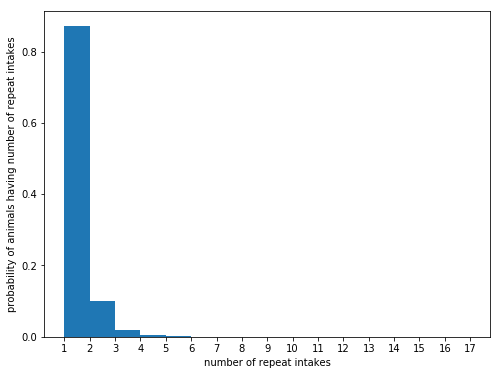

In [6]:
#plot of repeat intakes probability distribution.
plt.figure(figsize=(8,6))
plt.hist(dogs_in.animal_id.value_counts(), bins=range(1,18), normed=True)
plt.xticks(range(1,18))
plt.xlabel('number of repeat intakes')
plt.ylabel('probability of animals having number of repeat intakes')
plt.show()

In [7]:
#drop the animal_type column now that it's all dogs
dogs_in = dogs_in.drop(['animal_type'], axis=1)

#summary of dogs_in
print('The maximum number of repeat intakes is: {}'.format(dogs_in.animal_id.value_counts().max()))
print()
print(dogs_in.info())

The maximum number of repeat intakes is: 17

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49000 entries, 0 to 86618
Data columns (total 11 columns):
age_upon_intake     49000 non-null object
animal_id           49000 non-null object
breed               49000 non-null object
color               49000 non-null object
datetime            49000 non-null object
datetime2           49000 non-null object
found_location      49000 non-null object
intake_condition    49000 non-null object
intake_type         49000 non-null object
name                40977 non-null object
sex_upon_intake     49000 non-null object
dtypes: object(11)
memory usage: 4.5+ MB
None


In [8]:
#look at the dataframe
print(dogs_in.head())

  age_upon_intake animal_id                                  breed  \
0         8 years   A706918               English Springer Spaniel   
1       11 months   A724273                            Basenji Mix   
3         4 years   A682524  Doberman Pinsch/Australian Cattle Dog   
4         2 years   A743852                 Labrador Retriever Mix   
5         2 years   A708452                 Labrador Retriever Mix   

         color                 datetime                datetime2  \
0  White/Liver  2015-07-05T12:59:00.000  2015-07-05T12:59:00.000   
1  Sable/White  2016-04-14T18:43:00.000  2016-04-14T18:43:00.000   
3     Tan/Gray  2014-06-29T10:38:00.000  2014-06-29T10:38:00.000   
4    Chocolate  2017-02-18T12:46:00.000  2017-02-18T12:46:00.000   
5  Black/White  2015-07-30T14:37:00.000  2015-07-30T14:37:00.000   

                       found_location intake_condition      intake_type  \
0    9409 Bluegrass Dr in Austin (TX)           Normal            Stray   
1  2818 Palomino Tra

In [9]:
#look at name values
dogs_in.name

0               Belle
1             Runster
3                 Rio
4                Odin
5              Mumble
8                 NaN
9         *Candy Cane
10             *Pearl
15                NaN
16             Stumpy
18                NaN
20                NaN
21                NaN
24              Dieve
25             *Romeo
27             *Raven
30           *Wallace
32            Calseta
33              Boxer
34             Pepper
37             *Magic
43                NaN
44                NaN
49           Guardian
50                NaN
56           *Valerie
57                Oso
60              Chico
62           The Dude
63            Blackie
65          *Hercules
69           *Stanley
71            Dreamer
72          *Ladybird
74             London
75                NaN
78              Heidi
79              *Lila
83                Roo
84                Ash
90                NaN
93               Axle
97             Applez
98              China
99         Scooby Dee
100       

* After looking at the preliminary dataframe it seems:
    1. There are multiple intakes for the same pet.
    2. There are two date columns.
    3. The color attribute sometimes contains multiple colors.
    4. The age upon intake isn't machine digestable.
    5. There are nulls, No Name, and values with asteriks in the name column.
    6. The found location is too specific in some cases.
    7. Sex upon intake is actually two features in one column the sex and then the spay/neuter info as well.
    8. The breed sometimes contains mix, which can be a feature of its own.
    

* All these can be improved to be better features for input into machine learning algorithms and for EDA and statistical analysis.


****
* Let's get a deeper look into the feature issues and fix them.

    **1. Multiple intakes for the same pet.**
    
        Let's make a feature of this by adding a column of intake counts for the dogs.
        We will handle this last.

****
**2. There are two date columns.**
* The date needs to be in datetime format as well.

In [10]:
#delete the second date column and convert the date of the 1st date column to datetime
dogs_in = dogs_in.drop(['datetime2'], axis=1)

#strip off the time and just store with day time resolution
dates = dogs_in.datetime

#split datetime on the T and keep only the date part.
dogs_in.datetime = [date[0] for date in dates.str.split('T')]

#now convert datetime to datetime
dogs_in.datetime = pd.to_datetime(dogs_in.datetime)
dogs_in.datetime.unique()

array(['2015-07-05T00:00:00.000000000', '2016-04-14T00:00:00.000000000',
       '2014-06-29T00:00:00.000000000', ...,
       '2018-07-25T00:00:00.000000000', '2018-07-26T00:00:00.000000000',
       '2018-07-27T00:00:00.000000000'], dtype='datetime64[ns]')

**3. The color attribute sometimes contains multiple colors.**
* Split into two features color one and color two features/columns.

In [11]:
#create a dictionary of multiple colors with keys being the index and values being the list of colors
color_dict = defaultdict(str)
for index, color in enumerate(dogs_in.color):
    if str('/') in color:
        colors = color.split('/')
        color_dict[index] = colors
    else: 
        color_dict[index] = [color, 'None']

#assign new color1 and color2 columns and delete original color column
dogs_in['color1'] = [color[0] for key, color in color_dict.items()]
dogs_in['color2'] = [color[1] for key, color in color_dict.items()]
dogs_in = dogs_in.drop(['color'], axis=1)
print(dogs_in.color1.unique())
print(dogs_in.color2.unique())

['White' 'Sable' 'Tan' 'Chocolate' 'Black' 'Brown' 'Tricolor'
 'Brown Brindle' 'Brown Merle' 'Yellow' 'Blue' 'Gray' 'Buff' 'Cream' 'Red'
 'Blue Merle' 'Black Brindle' 'Blue Cream' 'Gold' 'Silver' 'Blue Tiger'
 'Fawn' 'Apricot' 'Red Merle' 'Blue Tick' 'Red Tick' 'Liver'
 'Yellow Brindle' 'Blue Smoke' 'Black Smoke' 'Liver Tick' 'Agouti' 'Orange'
 'Brown Tiger' 'Calico' 'Black Tiger' 'Ruddy']
['Liver' 'White' 'Gray' 'None' 'Tan' 'Black' 'Brown' 'Cream' 'Buff' 'Blue'
 'Brown Brindle' 'Blue Merle' 'Silver' 'Tricolor' 'Chocolate' 'Red'
 'Orange' 'Black Brindle' 'Brown Merle' 'Blue Tick' 'Gold' 'Black Tiger'
 'Red Tick' 'Brown Tabby' 'Yellow' 'Liver Tick' 'Yellow Brindle'
 'Red Merle' 'Brown Tiger' 'Black Smoke' 'Blue Tiger' 'Apricot' 'Fawn'
 'Blue Cream' 'Tortie' 'Pink' 'Gray Tiger']


**4. The age upon intake isn't machine digestable.**
* Make intake age in months.

In [12]:
#need to cycle through the date column and split on the space then calculate age in months based on years, months, weeks etc.
#first split the column into tuples
ages = [tuple([int(split[0]), split[1]]) for split in dogs_in.age_upon_intake.str.split(' ')]
periods = list(map(lambda t: t[1], ages))
unique_periods = list(pd.Series(periods).unique())
print('The unique time periods are: {}'.format(unique_periods))

The unique time periods are: ['years', 'months', 'month', 'year', 'week', 'weeks', 'days', 'day']


In [13]:
#The unique time periods are years, months, weeks, and days.  But we need to account for plurals vs. non plurals.
#make regular expressions.
year = re.compile('year*')
month = re.compile('month*')
week = re.compile('week*')
day = re.compile('day*')

#initiate list for ages
dog_ages = []
for amt, period in ages:
    if year.match(period):
        dog_ages.append(amt * 12)
    elif month.match(period):
        dog_ages.append(amt)
    elif week.match(period):
        dog_ages.append(amt/4) #assume that there are 4 weeks in a month
    else:
        dog_ages.append(amt/30) #assume that there are 30 days in a month

#add the month ages to the dogs_in dataframe
dogs_in['intake_age'] = dog_ages

#delete age_upon_intake from dogs_in
dogs_in =  dogs_in.drop(['age_upon_intake'], axis=1)
dogs_in.intake_age.unique()

array([  9.60000000e+01,   1.10000000e+01,   4.80000000e+01,
         2.40000000e+01,   5.00000000e+00,   2.00000000e+00,
         2.16000000e+02,   4.00000000e+00,   1.00000000e+00,
         1.20000000e+01,   6.00000000e+01,   3.60000000e+01,
         7.20000000e+01,   1.44000000e+02,   6.00000000e+00,
         2.50000000e-01,   7.00000000e+00,   1.08000000e+02,
         1.68000000e+02,   9.00000000e+00,   8.00000000e+00,
         8.40000000e+01,   0.00000000e+00,   1.20000000e+02,
         1.00000000e+01,   1.32000000e+02,   1.80000000e+02,
         1.56000000e+02,   1.00000000e-01,   3.00000000e+00,
         2.04000000e+02,   6.66666667e-02,   5.00000000e-01,
         2.28000000e+02,   3.33333333e-02,   1.92000000e+02,
         1.25000000e+00,   2.00000000e-01,   1.33333333e-01,
         7.50000000e-01,   2.40000000e+02,   1.66666667e-01,
         2.88000000e+02])

**5. There are nulls, No Name, and values with asteriks in the name column.**
* Replace nulls with None.
* Replace No Name with None.
* Strip asterik from those values that contain them.

In [14]:
#fill na with none, remove asteriks, and set No Name to None
dogs_in = dogs_in.fillna('None')
dogs_in.name = [name.replace('*','') if '*' in name else name for name in dogs_in.name]
dogs_in.name[dogs_in.name == 'No Name'] = 'None'

#check that there are no nulls in dogs_in
assert dogs_in.isnull().sum().sum() == 0
print(dogs_in.name.unique())

['Belle' 'Runster' 'Rio' ..., 'Loaf' 'Furman' 'Lanas']


C:\Users\sethh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


**6. The found location is too specific in some cases.**
* Only use the city and state, and then check the unique values.

In [15]:
#let's take a look at the data thus far
dogs_in.head()

,animal_id,breed,datetime,found_location,intake_condition,intake_type,name,sex_upon_intake,color1,color2,intake_age
0,A706918,English Springer Spaniel,2015-07-05,9409 Bluegrass Dr in Austin (TX),Normal,Stray,Belle,Spayed Female,White,Liver,96.0
1,A724273,Basenji Mix,2016-04-14,2818 Palomino Trail in Austin (TX),Normal,Stray,Runster,Intact Male,Sable,White,11.0
3,A682524,Doberman Pinsch/Australian Cattle Dog,2014-06-29,800 Grove Blvd in Austin (TX),Normal,Stray,Rio,Neutered Male,Tan,Gray,48.0
4,A743852,Labrador Retriever Mix,2017-02-18,Austin (TX),Normal,Owner Surrender,Odin,Neutered Male,Chocolate,None,24.0
5,A708452,Labrador Retriever Mix,2015-07-30,Austin (TX),Normal,Public Assist,Mumble,Intact Male,Black,White,24.0


In [16]:
#after looking at the unique values it seems we can split on space and concatenate the last two items
print(dogs_in.found_location.unique())
dogs_in['found_loc'] = [loc.split(' ')[-2] + ' ' + loc.split(' ')[-1]  for loc in dogs_in.found_location]

['9409 Bluegrass Dr in Austin (TX)' '2818 Palomino Trail in Austin (TX)'
 '800 Grove Blvd in Austin (TX)' ...,
 '1316 Town Center Drive in Pflugerville (TX)'
 'Longwood Road And Laurel Hill Street in Austin (TX)'
 '7113 East Us Hwy 290 Srvd Eb in Austin (TX)']


In [17]:
#After looking at the new unique values it's clear they are all in TX.
dogs_in.found_loc.unique()

#now drop the (TX) part.
TX = re.compile('(TX)')

locations = [loc[0:-5] if TX.search(loc) else loc for loc in dogs_in.found_loc]
print(pd.Series(locations).unique())

['Austin' 'Manor' 'Travis' 'Valle' 'Pflugerville' 'Outside Jurisdiction'
 'Leander' 'Jonestown' 'Rollingwood' 'Creedmoor' 'Rock' 'Bastrop' 'Ridge'
 'Park' 'Vista' 'Lakeway' 'Webberville' 'Williamson' 'Venture' 'Hays'
 'Cave' 'Valley' 'Hills' 'Caldwell' 'Blanco' 'Burnet']


In [18]:
#check to see if none of the unique values was lost
assert len(pd.Series(locations).unique()) == len(dogs_in.found_loc.unique())

In [19]:
#now set the found_location to locations and delete the original location from the dataframe
dogs_in.found_loc = locations
dogs_in = dogs_in.drop(['found_location'], axis=1)

**7. Sex upon intake is actually two features in one column the sex and then the spay/neuter info as well.**
* Split dual information into two columns.

In [20]:
#look at data in the column 
print(dogs_in.sex_upon_intake.unique())

#it seems there are null values here as well encoded as 'NULL', set to 'Unknown', split the double information into two columns
#create dictionary of lists of sex info
sex_dict = {index:(sex.split(' ') if str(' ') in sex 
            else ['Unknown', 'Unknown']) 
            for index, sex in enumerate(dogs_in.sex_upon_intake)}

#split dictionary info into two separate columns then delete the old sex_upon_intake column from the dataframe
dogs_in['intake_sex'] = [sex[1] for sex in sex_dict.values()]
dogs_in['intake_fixed'] = [sex[0] for sex in sex_dict.values()]
dogs_in = dogs_in.drop(['sex_upon_intake'], axis=1)

['Spayed Female' 'Intact Male' 'Neutered Male' 'Intact Female' 'Unknown'
 'NULL']


In [21]:
#make sure the unique values are correct.
print(dogs_in.intake_sex.unique())
print(dogs_in.intake_fixed.unique())

['Female' 'Male' 'Unknown']
['Spayed' 'Intact' 'Neutered' 'Unknown']


**8. The breed sometimes contains mix, which can be a feature of its own.**
* After cursory EDA, the data lists at most two breeds separated by '/'.  Sometimes Mix is thrown in.  
* The plan is to make two breed columns, and if the breed is a 'Mix' to label the breed 2 as 'Mix'.
* Also, if there is only one breed listed, the second breed will be 'None'.

In [22]:
#quick EDA on the dogs
for breed in dogs_in.breed.unique():
    print(breed)

English Springer Spaniel
Basenji Mix
Doberman Pinsch/Australian Cattle Dog
Labrador Retriever Mix
Chihuahua Shorthair
Pit Bull
Australian Cattle Dog/Labrador Retriever
Parson Russell Terrier Mix
Yorkshire Terrier Mix
Maltese Mix
Dachshund Mix
Plott Hound Mix
Pit Bull Mix
Tibetan Spaniel Mix
Miniature Pinscher Mix
Chihuahua Shorthair Mix
Dachshund/Chihuahua Shorthair
German Shepherd/Chow Chow
Miniature Schnauzer Mix
Great Pyrenees Mix
German Shepherd Mix
Feist/Beagle
American Pit Bull Terrier Mix
Rottweiler Mix
Chihuahua Shorthair/Jack Russell Terrier
Italian Greyhound Mix
Bull Terrier Mix
Boston Terrier/Pembroke Welsh Corgi
Black Mouth Cur Mix
German Shepherd/Great Pyrenees
Cairn Terrier Mix
Miniature Schnauzer/Miniature Poodle
American Bulldog Mix
Papillon Mix
Labrador Retriever/Beagle
Labrador Retriever/Border Collie
Siberian Husky Mix
Jack Russell Terrier Mix
Toy Fox Terrier Mix
Labrador Retriever/Rhod Ridgeback
Shih Tzu
Australian Cattle Dog
Rottweiler/German Shepherd
Basenji/Austr

Lhasa Apso/Miniature Schnauzer
Bull Terrier Miniature Mix
Belgian Tervuren Mix
Australian Shepherd/Catahoula
Rottweiler/Australian Cattle Dog
Flat Coat Retriever/Golden Retriever
Blue Lacy/Chinese Sharpei
Boxer/Harrier
Chinese Sharpei/Great Dane
Cairn Terrier/Italian Greyhound
Maltese/Shih Tzu
Great Pyrenees/Australian Shepherd
Bruss Griffon
Border Collie/Bull Terrier
Bearded Collie
Border Collie/Chow Chow
Toy Poodle/Cocker Spaniel
Australian Cattle Dog/German Shorthair Pointer
Cairn Terrier/Miniature Poodle
Old English Sheepdog Mix
Dachshund/Wire Hair Fox Terrier
Dachshund/Swedish Vallhund
Labrador Retriever/Redbone Hound
Chihuahua Shorthair/Schipperke
Chihuahua Longhair/Cavalier Span
Dachshund Longhair/Cocker Spaniel
German Shepherd/Vizsla
Jack Russell Terrier/Miniature Poodle
Rottweiler/Rhod Ridgeback
Rat Terrier/Miniature Poodle
German Shorthair Pointer
Redbone Hound/Dachshund
Cairn Terrier/Affenpinscher
Pembroke Welsh Corgi/Chihuahua Shorthair
Weimaraner/Pit Bull
Bouv Flandres/Ott

Chihuahua Longhair/Border Terrier
Cocker Spaniel/Toy Poodle
Border Collie/Norfolk Terrier
Collie Rough/Great Pyrenees
Dachshund/Greyhound
Labrador Retriever/English Pointer
Collie Rough/Catahoula
Dachshund Wirehair/West Highland
Airedale Terrier/Labrador Retriever
Chihuahua Shorthair/Cirneco
Pekingese/Jack Russell Terrier
Akita/Pit Bull
Border Collie/English Pointer
Black/Tan Hound/Labrador Retriever
Cairn Terrier/Scottish Terrier
Dachshund/Cavalier Span
Irish Terrier/Border Terrier
Queensland Heeler/Great Dane
Standard Poodle/Jack Russell Terrier
Boxer/English Bulldog
Border Terrier/Dachshund Wirehair
Border Collie/Bernese Mountain Dog
Catahoula/Staffordshire
Australian Shepherd/Alaskan Malamute
Dachshund/Yorkshire Terrier
Beagle/Cavalier Span
Miniature Schnauzer/Jack Russell Terrier
Dachshund Longhair/Pomeranian
Cocker Spaniel/Chihuahua Longhair
Anatol Shepherd/Border Collie
Dachshund Longhair/Miniature Poodle
Pit Bull/Pharaoh Hound
Irish Terrier/Labrador Retriever
Dachshund Longhair

In [23]:
#let's split the info on '/' if possible and separate information into two columns
#if 'Mix' in the breed info then add Mix to second breed column
#if only one breed listed, then second breed column will get 'None' value

#create dictionary with lists of breeds for each dog
breed_list = []
for breed in dogs_in.breed:
    if str('/') in breed:
        breed_list.append(breed.split('/'))
    elif 'Mix' in breed:
        breed_list.append([' '.join(breed.split(' ')[:-1]), breed.split(' ')[-1]])
    else:
        breed_list.append([breed, 'None'])

dogs_in['breed1'] = [breed[0] for breed in breed_list]
dogs_in['breed2'] = [breed[1] for breed in breed_list]
dogs_in = dogs_in.drop(['breed'], axis=1)

In [24]:
#check new unique breeds
print(dogs_in.breed1.value_counts())
print(dogs_in.breed2.value_counts())

Pit Bull                              7449
Labrador Retriever                    6813
Chihuahua Shorthair                   6128
German Shepherd                       2840
Australian Cattle Dog                 1537
Dachshund                             1303
Boxer                                 1029
Border Collie                         1006
Miniature Poodle                       884
Siberian Husky                         699
Beagle                                 697
Catahoula                              692
Australian Shepherd                    684
Yorkshire Terrier                      680
Jack Russell Terrier                   661
Rat Terrier                            633
Miniature Schnauzer                    618
Great Pyrenees                         564
Rottweiler                             538
Pointer                                497
Staffordshire                          496
Shih Tzu                               495
Chihuahua Longhair                     477
Cairn Terri

In [25]:
print(len(dogs_in.breed1.value_counts()))
print(len(dogs_in.breed2.value_counts()))

197
162


* The total breed count is within the amount of recognized breeds by the AKC which is 192, so the data seems good.  Some more altering and narrowing down of categories for breed can be done later for the machine learning predicting step. 
    * Such as grouping all hounds or terriers together.
    
**1. Multiple intakes for the same pet.**
* Let's account for the repeat intakes by making a column that contains the order of the intake.

In [26]:
#first sort the dogs_in dataframe by animal_id and datetime, reset the index, and drop_duplicate rows.
dogs_in = dogs_in.sort_values(['animal_id','datetime'])
dogs_in = dogs_in.drop_duplicates()
dogs_in = dogs_in.reset_index(drop=True)

#add a blank series to the dataframe "intake"
dogs_in['intake'] = np.nan
for index, row in dogs_in.iterrows():
    if index == 0:
        dogs_in.loc[index, 'intake'] = 1
    else:
        if row['animal_id'] == dogs_in.loc[index - 1, 'animal_id']:
            dogs_in.loc[index, 'intake'] = dogs_in.loc[index - 1, 'intake'] + 1
        else:
            dogs_in.loc[index, 'intake'] = 1

In [27]:
#check unique values and dataframe head
print('The unique intake orders are: {}'.format(dogs_in.intake.unique()))

#change float type to int type
dogs_in.intake = dogs_in.intake.astype(int)
dogs_in.head(5)

The unique intake orders are: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.]


,animal_id,datetime,intake_condition,intake_type,name,color1,color2,intake_age,found_loc,intake_sex,intake_fixed,breed1,breed2,intake
0,A006100,2014-03-07,Normal,Public Assist,Scamp,Yellow,White,72.0,Austin,Male,Neutered,Spinone Italiano,Mix,1
1,A006100,2014-12-19,Normal,Public Assist,Scamp,Yellow,White,84.0,Austin,Male,Neutered,Spinone Italiano,Mix,2
2,A006100,2017-12-07,Normal,Stray,Scamp,Yellow,White,120.0,Austin,Male,Neutered,Spinone Italiano,Mix,3
3,A047759,2014-04-02,Normal,Owner Surrender,Oreo,Tricolor,None,120.0,Austin,Male,Neutered,Dachshund,None,1
4,A134067,2013-11-16,Injured,Public Assist,Bandit,Brown,White,192.0,Austin,Male,Neutered,Shetland Sheepdog,None,1


* Now the intake dataframe is wrangled.  Let's work on the outtake dataframe in roughly the same manner.

****

### B) Outtake Data

In [28]:
#now let's download the outtake data
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.austintexas.gov", None)

# First 100000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
#right now the data base says it contains 84669 entries so setting the limit to 100000.  
#The better way to do it would be to set up a requests download while loop with a urllib HTTPError catch.
#This would ensure that all the data would be captured, but this is good for my purposes here.
results = client.get("hcup-htgu", limit=100000)
print('The number of entries is: {}'.format(len(results)))

The number of entries is: 86358


In [29]:
#Now convert the list of dictionaries to a dataframe with the animal id as the index
outtakes = pd.DataFrame(results).reset_index(drop=True)

In [30]:
#dataframe info
print(outtakes.info())
print()
print("Animal Types in out takes.")
print(outtakes.animal_type.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86358 entries, 0 to 86357
Data columns (total 12 columns):
age_upon_outcome    86358 non-null object
animal_id           86358 non-null object
animal_type         86358 non-null object
breed               86358 non-null object
color               86358 non-null object
date_of_birth       86358 non-null object
datetime            86358 non-null object
monthyear           86358 non-null object
name                59555 non-null object
outcome_subtype     39558 non-null object
outcome_type        86343 non-null object
sex_upon_outcome    86358 non-null object
dtypes: object(12)
memory usage: 7.9+ MB
None

Animal Types in out takes.
Dog          48942
Cat          32278
Other         4751
Bird           377
Livestock       10
Name: animal_type, dtype: int64


In [31]:
#Filter outtakes for dogs only.
dogs_out = outtakes[outtakes.animal_type == 'Dog']

#save dataframes to csv
outtakes.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/outtakes.csv', index=False)
dogs_out.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_out.csv', index=False)

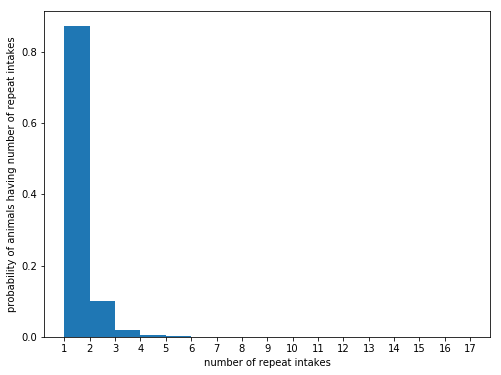

In [32]:
#plot of repeat outtakes probability distribution.
plt.figure(figsize=(8,6))
plt.hist(dogs_out.animal_id.value_counts(), bins=range(1,18), normed=True)
plt.xticks(range(1,18))
plt.xlabel('number of repeat intakes')
plt.ylabel('probability of animals having number of repeat intakes')
plt.show()

In [33]:
#dogs out multiple outtakes to check against dogs in
print(dogs_out.animal_id.value_counts())

#summary of dogs_out
print('The maximum number of repeat intakes is: {}'.format(dogs_out.animal_id.value_counts().max()))
print()
assert list(dogs_in.animal_id.value_counts()) == list(dogs_out.animal_id.value_counts())

A721033    17
A718223    13
A706536    11
A716018     9
A670612     8
A616444     8
A694501     8
A738324     8
A738073     8
A683108     7
A701901     7
A737854     7
A693283     7
A593537     7
A671704     7
A678294     7
A735601     7
A701265     7
A704287     7
A693282     6
A695857     6
A623561     6
A683030     6
A730415     6
A733594     6
A740335     6
A663819     6
A719117     6
A720278     6
A705625     6
A732618     6
A615920     6
A667894     6
A676423     6
A690234     6
A703649     6
A678174     6
A700396     6
A688610     6
A718877     6
A675366     6
A690543     6
A665334     6
A462580     6
A671822     5
A739650     5
A753449     5
A720393     5
A717053     5
A740698     5
A709390     5
A677853     5
A700407     5
A758365     5
A701879     5
A742163     5
A705228     5
A693266     5
A735303     5
A735302     5
A767459     5
A738268     5
A741582     5
A739197     5
A664228     5
A681769     5
A704998     5
A738679     5
A705236     5
A672216     5
A687360     5
A66745

AssertionError: 

* It appears the multiple outtakes per animal don't exactly match with the multiple intakes per animal.

In [34]:
#see which columns are relevant in dogs out
dogs_out.head(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,1 year,A776359,Dog,Chihuahua Shorthair Mix,White/Brown,2017-07-12T00:00:00.000,2018-07-18T16:02:00.000,2018-07-18T16:02:00.000,Gizmo,NaN,Adoption,Neutered Male
1,4 months,A720371,Dog,Anatol Shepherd/Labrador Retriever,Buff,2015-10-08T00:00:00.000,2016-02-13T17:59:00.000,2016-02-13T17:59:00.000,Moose,NaN,Adoption,Neutered Male
12,9 years,A765349,Dog,Chihuahua Shorthair Mix,Tricolor,2009-01-18T00:00:00.000,2018-06-08T13:04:00.000,2018-06-08T13:04:00.000,Einstein,Foster,Adoption,Neutered Male
13,10 years,A760697,Dog,Yorkshire Terrier Mix,Brown/Black,2007-10-23T00:00:00.000,2017-10-26T15:22:00.000,2017-10-26T15:22:00.000,Star,Partner,Transfer,Intact Male
14,1 year,A767231,Dog,Jack Russell Terrier/Chihuahua Shorthair,White/Tan,2017-02-25T00:00:00.000,2018-02-25T17:19:00.000,2018-02-25T17:19:00.000,Millie,NaN,Return to Owner,Spayed Female


* As we are trying to predict adoption outcomes based on intake data the only relevant information from the outtake data is the outcome type and subtype, age upon outtake/outtake date.
* It may however be interesting to do EDA on the outtake data as well and compare to the intake data.
    * The data will be prepped for machine learning later in the machine learning step.
    

* For the EDA prep, assume that color and breed don't change from intake to outtake.

In [35]:
#drop the redundant columns
dogs_out = dogs_out.drop(['animal_type','color','date_of_birth','monthyear'], axis=1)

In [36]:
#now look at dataframe summary
print(dogs_out.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48942 entries, 0 to 86353
Data columns (total 8 columns):
age_upon_outcome    48942 non-null object
animal_id           48942 non-null object
breed               48942 non-null object
datetime            48942 non-null object
name                40969 non-null object
outcome_subtype     14895 non-null object
outcome_type        48940 non-null object
sex_upon_outcome    48942 non-null object
dtypes: object(8)
memory usage: 3.4+ MB
None


In [37]:
#look at unique values for each column
for col in dogs_out.columns:
    print(dogs_out[col].unique())

['1 year' '4 months' '9 years' '10 years' '8 years' '3 years' '2 years'
 '7 months' '6 years' '4 years' '2 months' '12 years' '5 years' '6 months'
 '9 months' '1 month' '3 months' '7 years' '11 months' '10 months'
 '8 months' '11 years' '6 days' '14 years' '15 years' '5 months' '16 years'
 '1 weeks' '1 day' '13 years' '3 weeks' '2 days' '2 weeks' '4 weeks'
 '3 days' '17 years' '4 days' '18 years' '1 week' '5 days' '0 years'
 '5 weeks' '19 years' 'NULL' '20 years' '24 years']
['A776359' 'A720371' 'A765349' ..., 'A777102' 'A774198' 'A763740']
['Chihuahua Shorthair Mix' 'Anatol Shepherd/Labrador Retriever'
 'Yorkshire Terrier Mix' ..., 'Catahoula/Queensland Heeler'
 'Collie Smooth/Catahoula' 'Plott Hound/Catahoula']
['2018-07-18T16:02:00.000' '2016-02-13T17:59:00.000'
 '2018-06-08T13:04:00.000' ..., '2018-07-12T16:16:00.000'
 '2017-12-17T14:20:00.000' '2018-07-27T18:52:00.000']
['Gizmo' 'Moose' 'Einstein' ..., 'Popo' '*Rover' '*Furman']
[nan 'Foster' 'Partner' 'Aggressive' 'Suffering' 'Of

* It seems we have the similar issues to the intake data which can be fixed in the same manner.

1. The age upon intake isn't machine digestable.
2. There are nulls, No Name, and values with asteriks in the name column.
3. Sex upon outtake is actually two features in one column the sex and then the spay/neuter info as well.
4. Need to parse the datetime column.
5. Outcome type has 'nan' as a value and contains nulls.
6. Outcome subtype has 'nan' as a value and contains nulls.
7. There are multiple outtake per animals.

****

**1. The age upon intake isn't machine digestable.**
* There is also 'Null' values.
    * Make NaN for calculation then code back into 'Unknown'.
* Do the calculation the same as the intake data i.e. splitting the number from the word moniker, and calculating the age in months.

In [38]:
#need to cycle through the date column and split on the space then calculate age in months based on years, months, weeks etc.
#first split the column into tuples
ages = ['Unknown' if age == 'NULL' else age.split(' ') for age in dogs_out.age_upon_outcome]
periods = [age[1] if not age == 'Unknown' else 'Unknown' for age in ages] 
unique_periods = list(pd.Series(periods).unique())
print(unique_periods)

['year', 'months', 'years', 'month', 'days', 'weeks', 'day', 'week', 'Unknown']


In [39]:
#The unique time periods are years, months, weeks, and days.  But we need to account for plurals and non plurals.
#make regular expressions.
year = re.compile('year*')
month = re.compile('month*')
week = re.compile('week*')
day = re.compile('day*')

#initiate list for ages
dog_ages = []
for age in ages:
    if not age == 'Unknown':
    
        if year.match(age[1]):
            dog_ages.append(int(age[0]) * 12)
        elif month.match(age[1]):
            dog_ages.append(int(age[0]))
        elif week.match(age[1]):
            dog_ages.append(int(age[0])/4) #assume that there are 4 weeks in a month
        else:
            dog_ages.append(int(age[0])/30) #assume that there are 30 days in a month
            
    else:
        dog_ages.append('Unknown')

#add the month ages to the dogs_in dataframe
dogs_out['outtake_age'] = dog_ages

#delete age_upon_outcome from dogs_in
dogs_out = dogs_out.drop(['age_upon_outcome'], axis=1)
dogs_out.outtake_age.unique()

array([12, 4, 108, 120, 96, 36, 24, 7, 72, 48, 2, 144, 60, 6, 9, 1, 3, 84,
       11, 10, 8, 132, 0.2, 168, 180, 5, 192, 0.25, 0.03333333333333333,
       156, 0.75, 0.06666666666666667, 0.5, 0.1, 204, 0.13333333333333333,
       216, 0.16666666666666666, 0, 1.25, 228, 'Unknown', 240, 288], dtype=object)

**2. There are nulls, No Name, and values with asteriks in the name column.**
* Replace nulls with None.
* Replace No Name with None.
* Strip asterik from those values that contain them.

In [40]:
#fill na with none, remove asteriks, and set No Name to None
dogs_out = dogs_out.fillna('Unknown')
dogs_out.name = [name.replace('*','') if '*' in name else name for name in dogs_out.name]
dogs_out.name[dogs_out.name == 'No Name'] = 'Unknown'

#check that there are no nulls in dogs_in
assert dogs_out.isnull().sum().sum() == 0
print(dogs_out.name.unique())

['Gizmo' 'Moose' 'Einstein' ..., 'Micky' 'Popo' 'Furman']


**3. Sex upon outtake is actually two features in one column the sex and then the spay/neuter info as well.**
* Split information into two columns.

In [41]:
#look at data in the column 
print(dogs_out.sex_upon_outcome.unique())

#it seems there are null values here as well encoded as 'NULL', set to 'Unknown', split the double information into two columns
#create dictionary of lists of sex info
sex_dict = {index:(sex.split(' ') if str(' ') in sex 
            else ['Unknown', 'Unknown']) 
            for index, sex in enumerate(dogs_out.sex_upon_outcome)}

#split dictionary info into two separate columns then delete the old sex_upon_intake column from the dataframe
dogs_out['outtake_sex'] = [sex[1] for sex in sex_dict.values()]
dogs_out['outtake_fixed'] = [sex[0] for sex in sex_dict.values()]
dogs_out = dogs_out.drop(['sex_upon_outcome'], axis=1)

['Neutered Male' 'Intact Male' 'Spayed Female' 'Intact Female' 'Unknown'
 'NULL']


In [42]:
#make sure the unique values are correct.
print(dogs_out.outtake_sex.unique())
print(dogs_out.outtake_fixed.unique())

['Male' 'Female' 'Unknown']
['Neutered' 'Intact' 'Spayed' 'Unknown']


**4. Need to parse the datetime column.**

In [43]:
#strip off the time and just store with day time resolution
dates = dogs_out.datetime

#split datetime on the T and keep only the date part.
dogs_out.datetime = [date[0] for date in dates.str.split('T')]

#now convert datetime to datetime
dogs_out.datetime = pd.to_datetime(dogs_out.datetime)
dogs_out.datetime.unique()

array(['2018-07-18T00:00:00.000000000', '2016-02-13T00:00:00.000000000',
       '2018-06-08T00:00:00.000000000', ...,
       '2018-07-25T00:00:00.000000000', '2018-07-26T00:00:00.000000000',
       '2018-07-27T00:00:00.000000000'], dtype='datetime64[ns]')

**5 & 6. Outcome type has 'nan' as a value and contains nulls.**
* The nans and were replaced with 'Unknown' in a previous step.

In [44]:
#check unique values of both outcome type and subtype
print(dogs_out.outcome_subtype.unique())
print(dogs_out.outcome_type.unique())

['Unknown' 'Foster' 'Partner' 'Aggressive' 'Suffering' 'Offsite'
 'In Kennel' 'At Vet' 'Behavior' 'Medical' 'Rabies Risk' 'Possible Theft'
 'In Foster' 'Court/Investigation' 'In Surgery' 'Enroute' 'Barn']
['Adoption' 'Transfer' 'Return to Owner' 'Euthanasia' 'Rto-Adopt' 'Died'
 'Missing' 'Unknown' 'Disposal']


**7. There are multiple outtakes per animal.**
* Create a column with outtake order per animal outtake similar to what was done to keep track of the multiple intakes order.

In [45]:
#first sort the dogs_in dataframe by animal_id and datetime, reset the index, and drop_duplicate rows.
dogs_out = dogs_out.sort_values(['animal_id','datetime'])
dogs_out = dogs_out.drop_duplicates()
dogs_out = dogs_out.reset_index(drop=True)

#add a blank series to the dataframe "intake"
dogs_out['outtake'] = np.nan
for index, row in dogs_out.iterrows():
    if index == 0:
        dogs_out.loc[index, 'outtake'] = 1
    else:
        if row['animal_id'] == dogs_out.loc[index - 1, 'animal_id']:
            dogs_out.loc[index, 'outtake'] = dogs_out.loc[index - 1, 'outtake'] + 1
        else:
            dogs_out.loc[index, 'outtake'] = 1

In [46]:
#check unique values and dataframe head
print('The unique intake orders are: {}'.format(dogs_out.outtake.unique()))

#change float type to int type
dogs_out.outtake = dogs_out.outtake.astype(int)
dogs_out.head(5)

The unique intake orders are: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.]


,animal_id,breed,datetime,name,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake
0,A006100,Spinone Italiano Mix,2014-03-08,Scamp,Unknown,Return to Owner,72,Male,Neutered,1
1,A006100,Spinone Italiano Mix,2014-12-20,Scamp,Unknown,Return to Owner,84,Male,Neutered,2
2,A006100,Spinone Italiano Mix,2017-12-07,Scamp,Unknown,Return to Owner,120,Male,Neutered,3
3,A047759,Dachshund,2014-04-07,Oreo,Partner,Transfer,120,Male,Neutered,1
4,A134067,Shetland Sheepdog,2013-11-16,Bandit,Unknown,Return to Owner,192,Male,Neutered,1


* Now the outtake dataframe is wrangled.  Let's work on the joining the dataframes.

****

### C. Join and Save Dataframes
* Save the wrangled dataframes.
* Join the intake and outtake dataframes based on animal_id and intake outtake values, which when combined provide a completely unique animal identifier upon individual intakes.

In [47]:
#save the wrangled dataframes
dogs_out.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_out_wrangled.csv', index=False)
dogs_in.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_in_wrangled.csv', index=False)

* Let's examine the dataframes one more time before joining on the common unique keys in each dataframe, the 'animal_id' and 'intake'/'outtake' columns.

In [48]:
print('Intake Data Summary')
print(dogs_in.info())
print()
print('Outtake Data Summary')
print(dogs_out.info())

Intake Data Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48993 entries, 0 to 48992
Data columns (total 14 columns):
animal_id           48993 non-null object
datetime            48993 non-null datetime64[ns]
intake_condition    48993 non-null object
intake_type         48993 non-null object
name                48993 non-null object
color1              48993 non-null object
color2              48993 non-null object
intake_age          48993 non-null float64
found_loc           48993 non-null object
intake_sex          48993 non-null object
intake_fixed        48993 non-null object
breed1              48993 non-null object
breed2              48993 non-null object
intake              48993 non-null int32
dtypes: datetime64[ns](1), float64(1), int32(1), object(11)
memory usage: 5.0+ MB
None

Outtake Data Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48929 entries, 0 to 48928
Data columns (total 10 columns):
animal_id          48929 non-null object
breed           

* There seems to be less data in the outtake than the intake maybe suggesting that there are still roughly 100 animals in the shelter.
    * Before joining the dataframes, let's see if there are any outtakes that don't appear in the intakes as this means there may be missing data and/or clerical/other errors.
    * Also, these "extra" outtakes would throw off the intake outtake difference, among other calculations.

In [49]:
#check for outtakes with no intake.
in_id = set(dogs_in.animal_id)
out_id = set(dogs_out.animal_id)
diff = list(out_id.difference(in_id))
print('There are {} outtakes that don\'t have an intake.'.format(len(diff)))

There are 381 outtakes that don't have an intake.


* 381 "extra" outtakes out of ~ 84000 isn't that many.  We don't need to worry about these being merged into the joined dataframe.

In [50]:
#merge the dataframes
dogs_join = dogs_in.merge(dogs_out, how='left', left_on=['animal_id','intake'], right_on=['animal_id','outtake'], 
                          suffixes=('_in','_out'), copy=False)

#look at the merged dataframe
dogs_join.head(10)

,animal_id,datetime_in,intake_condition,intake_type,name_in,color1,color2,intake_age,found_loc,intake_sex,intake_fixed,breed1,breed2,intake,breed,datetime_out,name_out,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake
0,A006100,2014-03-07,Normal,Public Assist,Scamp,Yellow,White,72.0,Austin,Male,Neutered,Spinone Italiano,Mix,1,Spinone Italiano Mix,2014-03-08,Scamp,Unknown,Return to Owner,72,Male,Neutered,1.0
1,A006100,2014-12-19,Normal,Public Assist,Scamp,Yellow,White,84.0,Austin,Male,Neutered,Spinone Italiano,Mix,2,Spinone Italiano Mix,2014-12-20,Scamp,Unknown,Return to Owner,84,Male,Neutered,2.0
2,A006100,2017-12-07,Normal,Stray,Scamp,Yellow,White,120.0,Austin,Male,Neutered,Spinone Italiano,Mix,3,Spinone Italiano Mix,2017-12-07,Scamp,Unknown,Return to Owner,120,Male,Neutered,3.0
3,A047759,2014-04-02,Normal,Owner Surrender,Oreo,Tricolor,None,120.0,Austin,Male,Neutered,Dachshund,None,1,Dachshund,2014-04-07,Oreo,Partner,Transfer,120,Male,Neutered,1.0
4,A134067,2013-11-16,Injured,Public Assist,Bandit,Brown,White,192.0,Austin,Male,Neutered,Shetland Sheepdog,None,1,Shetland Sheepdog,2013-11-16,Bandit,Unknown,Return to Owner,192,Male,Neutered,1.0
5,A141142,2013-11-16,Aged,Stray,Bettie,Black,White,180.0,Austin,Female,Spayed,Labrador Retriever,Pit Bull,1,Labrador Retriever/Pit Bull,2013-11-17,Bettie,Unknown,Return to Owner,180,Female,Spayed,1.0
6,A163459,2014-11-14,Normal,Stray,Sasha,Black,Gray,180.0,Austin,Female,Intact,Miniature Schnauzer,Mix,1,Miniature Schnauzer Mix,2014-11-14,Sasha,Unknown,Return to Owner,180,Female,Intact,1.0
7,A165752,2014-09-15,Normal,Stray,Pep,Brown,White,180.0,Austin,Male,Neutered,Lhasa Apso,Mix,1,Lhasa Apso Mix,2014-09-15,Pep,Unknown,Return to Owner,180,Male,Neutered,1.0
8,A178569,2014-03-17,Normal,Public Assist,Boti,White,Black,180.0,Austin,Male,Neutered,Shetland Sheepdog,Mix,1,Shetland Sheepdog Mix,2014-03-23,Boti,Unknown,Return to Owner,180,Male,Neutered,1.0
9,A189592,2015-09-18,Normal,Stray,Ophelia,Brown,White,216.0,Austin,Female,Spayed,Shetland Sheepdog,Mix,1,Shetland Sheepdog Mix,2015-09-18,Ophelia,Unknown,Return to Owner,216,Female,Spayed,1.0


In [51]:
#let's check the info again which should have the same number of rows as the intake dataframe 
#due to the left join and unique animal ids
dogs_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48993 entries, 0 to 48992
Data columns (total 23 columns):
animal_id           48993 non-null object
datetime_in         48993 non-null datetime64[ns]
intake_condition    48993 non-null object
intake_type         48993 non-null object
name_in             48993 non-null object
color1              48993 non-null object
color2              48993 non-null object
intake_age          48993 non-null float64
found_loc           48993 non-null object
intake_sex          48993 non-null object
intake_fixed        48993 non-null object
breed1              48993 non-null object
breed2              48993 non-null object
intake              48993 non-null int32
breed               48475 non-null object
datetime_out        48475 non-null datetime64[ns]
name_out            48475 non-null object
outcome_subtype     48475 non-null object
outcome_type        48475 non-null object
outtake_age         48475 non-null object
outtake_sex         48475 non-null 

* We see that the over length of the dataframe matches up.  
* Also, there were less outtakes than intakes as expected.  I will leave those a null values for easy identification and counting later on in the EDA with isnull() methods and the like.
* We can add one more column the joined dataframe which will be a time in shelter and will contain the difference in days between intake and outtake.

In [52]:
#add the time in shelter column to the joined dataframe
dogs_join['shelter_time'] = [(row['datetime_out'] - row['datetime_in']).days for _, row in dogs_join.iterrows()]
dogs_join.head(10)

,animal_id,datetime_in,intake_condition,intake_type,name_in,color1,color2,intake_age,found_loc,intake_sex,intake_fixed,breed1,breed2,intake,breed,datetime_out,name_out,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake,shelter_time
0,A006100,2014-03-07,Normal,Public Assist,Scamp,Yellow,White,72.0,Austin,Male,Neutered,Spinone Italiano,Mix,1,Spinone Italiano Mix,2014-03-08,Scamp,Unknown,Return to Owner,72,Male,Neutered,1.0,1.0
1,A006100,2014-12-19,Normal,Public Assist,Scamp,Yellow,White,84.0,Austin,Male,Neutered,Spinone Italiano,Mix,2,Spinone Italiano Mix,2014-12-20,Scamp,Unknown,Return to Owner,84,Male,Neutered,2.0,1.0
2,A006100,2017-12-07,Normal,Stray,Scamp,Yellow,White,120.0,Austin,Male,Neutered,Spinone Italiano,Mix,3,Spinone Italiano Mix,2017-12-07,Scamp,Unknown,Return to Owner,120,Male,Neutered,3.0,0.0
3,A047759,2014-04-02,Normal,Owner Surrender,Oreo,Tricolor,None,120.0,Austin,Male,Neutered,Dachshund,None,1,Dachshund,2014-04-07,Oreo,Partner,Transfer,120,Male,Neutered,1.0,5.0
4,A134067,2013-11-16,Injured,Public Assist,Bandit,Brown,White,192.0,Austin,Male,Neutered,Shetland Sheepdog,None,1,Shetland Sheepdog,2013-11-16,Bandit,Unknown,Return to Owner,192,Male,Neutered,1.0,0.0
5,A141142,2013-11-16,Aged,Stray,Bettie,Black,White,180.0,Austin,Female,Spayed,Labrador Retriever,Pit Bull,1,Labrador Retriever/Pit Bull,2013-11-17,Bettie,Unknown,Return to Owner,180,Female,Spayed,1.0,1.0
6,A163459,2014-11-14,Normal,Stray,Sasha,Black,Gray,180.0,Austin,Female,Intact,Miniature Schnauzer,Mix,1,Miniature Schnauzer Mix,2014-11-14,Sasha,Unknown,Return to Owner,180,Female,Intact,1.0,0.0
7,A165752,2014-09-15,Normal,Stray,Pep,Brown,White,180.0,Austin,Male,Neutered,Lhasa Apso,Mix,1,Lhasa Apso Mix,2014-09-15,Pep,Unknown,Return to Owner,180,Male,Neutered,1.0,0.0
8,A178569,2014-03-17,Normal,Public Assist,Boti,White,Black,180.0,Austin,Male,Neutered,Shetland Sheepdog,Mix,1,Shetland Sheepdog Mix,2014-03-23,Boti,Unknown,Return to Owner,180,Male,Neutered,1.0,6.0
9,A189592,2015-09-18,Normal,Stray,Ophelia,Brown,White,216.0,Austin,Female,Spayed,Shetland Sheepdog,Mix,1,Shetland Sheepdog Mix,2015-09-18,Ophelia,Unknown,Return to Owner,216,Female,Spayed,1.0,0.0


In [53]:
dogs_join.shelter_time.unique()

array([  1.00000000e+00,   0.00000000e+00,   5.00000000e+00,
         6.00000000e+00,   5.00000000e+01,   9.00000000e+00,
         1.10000000e+01,   2.30000000e+01,   4.00000000e+00,
         8.00000000e+00,   9.00000000e+01,   7.00000000e+00,
         3.00000000e+00,   1.47000000e+02,   1.48000000e+02,
         2.00000000e+00,   1.00000000e+01,   2.80000000e+01,
         2.70000000e+01,   5.80000000e+01,   3.90000000e+01,
         2.10000000e+01,   3.49000000e+02,   1.60000000e+01,
         1.90000000e+01,   3.80000000e+01,   8.80000000e+01,
         2.02000000e+02,   1.20000000e+01,   1.23000000e+02,
         1.07000000e+02,   1.50000000e+01,   2.20000000e+01,
         6.60000000e+01,   1.20000000e+02,   1.30000000e+01,
         3.10000000e+01,   8.00000000e+01,   1.31000000e+02,
         1.24000000e+02,   2.50000000e+01,   1.40000000e+01,
         5.50000000e+01,   2.62000000e+02,   4.10000000e+01,
         6.10000000e+01,   6.42000000e+02,   1.80000000e+01,
         3.75000000e+02,

In [54]:
negatives = dogs_join.loc[dogs_join.shelter_time < 0]
negatives

,animal_id,datetime_in,intake_condition,intake_type,name_in,color1,color2,intake_age,found_loc,intake_sex,intake_fixed,breed1,breed2,intake,breed,datetime_out,name_out,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake,shelter_time
683,A531739,2014-07-20,Normal,Owner Surrender,Bentley,White,Tan,72.0,Austin,Male,Neutered,Pointer,Mix,1,Pointer Mix,2013-11-30,Bentley,Unknown,Adoption,60,Male,Neutered,1.0,-232.0
1627,A605223,2014-07-13,Normal,Owner Surrender,Coconut,Black,White,36.0,Austin,Female,Spayed,Pit Bull,Mix,1,Pit Bull Mix,2014-07-05,Coconut,Unknown,Adoption,36,Female,Spayed,1.0,-8.0
1642,A605804,2015-03-15,Normal,Public Assist,Shayla,White,Black,48.0,Austin,Female,Spayed,Australian Cattle Dog,Mix,1,Australian Cattle Dog Mix,2014-07-22,Shayla,Unknown,Adoption,36,Female,Spayed,1.0,-236.0
1722,A609335,2013-12-19,Normal,Owner Surrender,Churley,White,Tan,48.0,Hays,Male,Neutered,Pit Bull,Mix,1,Pit Bull Mix,2013-12-16,Churley,Unknown,Adoption,48,Male,Neutered,1.0,-3.0
1843,A613553,2015-02-08,Normal,Euthanasia Request,Beast,Black,White,48.0,Austin,Male,Neutered,Pit Bull,Mix,1,Pit Bull Mix,2013-10-01,Beast,Unknown,Return to Owner,36,Male,Neutered,1.0,-495.0
2044,A620178,2014-03-25,Normal,Owner Surrender,Melody,Brown,White,48.0,Austin,Female,Spayed,Dogue De Bordeaux,Mix,1,Dogue De Bordeaux Mix,2014-03-13,Melody,Unknown,Adoption,48,Female,Spayed,1.0,-12.0
2115,A622128,2014-01-27,Normal,Owner Surrender,Ginger,Brown Brindle,White,12.0,Austin,Female,Spayed,Boxer,Mix,1,Boxer Mix,2014-01-19,Ginger,Unknown,Adoption,12,Female,Spayed,1.0,-8.0
2120,A622215,2014-07-28,Normal,Owner Surrender,Herk,Red,White,60.0,Austin,Male,Neutered,American Pit Bull Terrier,Mix,1,American Pit Bull Terrier Mix,2014-07-27,Herk,Unknown,Adoption,60,Male,Neutered,1.0,-1.0
2345,A631581,2014-02-01,Normal,Owner Surrender,Lola,Black,White,48.0,Austin,Female,Spayed,Bull Terrier,Mix,1,Bull Terrier Mix,2014-01-04,Lola,Foster,Adoption,48,Female,Spayed,1.0,-28.0
2383,A632791,2018-01-21,Normal,Owner Surrender,Leonard,Black,None,84.0,Austin,Male,Neutered,Labrador Retriever,Mix,1,Labrador Retriever Mix,2014-08-15,Leonard,Foster,Adoption,48,Male,Neutered,1.0,-1255.0


In [55]:
dogs_join.loc[dogs_join.animal_id == 'A531739']

,animal_id,datetime_in,intake_condition,intake_type,name_in,color1,color2,intake_age,found_loc,intake_sex,intake_fixed,breed1,breed2,intake,breed,datetime_out,name_out,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake,shelter_time
683,A531739,2014-07-20,Normal,Owner Surrender,Bentley,White,Tan,72.0,Austin,Male,Neutered,Pointer,Mix,1,Pointer Mix,2013-11-30,Bentley,Unknown,Adoption,60,Male,Neutered,1.0,-232.0


* There are negative values of the time to adoption.  This means the merge of the intake and outtake dataframes wasn't 100% successful.  
    * First, let's pick out the negative value then explore them in the dataframe to see what's going on.
    
* After exploring the negative results, it seems that the intake and outtake times are switched for these instances.
    * Account for this by looping through the joined data again and accounting for the error by making sure that the outtake datetime is greater than the intake datetime and switching dates if this is not true.

In [56]:
#loop through and swap troublesome dates and flip the sign on shelter_time
for index, row in dogs_join.iterrows():
    if row['shelter_time'] < 0:
        temp_date = row['datetime_in']
        dogs_join.loc[index, 'datetime_in'] = dogs_join.loc[index, 'datetime_out']
        dogs_join.loc[index, 'datetime_out'] = temp_date
        dogs_join.loc[index, 'shelter_time'] = -1 * row['shelter_time']
        

In [57]:
#check to see if there are any more negative entries for time to adoption
len(dogs_join.loc[dogs_join.shelter_time < 0]['shelter_time'])


0

In [58]:
#save the joined dataframe
dogs_join.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join.csv', index=False)

* Data Wrangling is completed info to do Exploratory Data Analysis.
    * Further Wrangling will be needed in order to input the data into Machine Learning Models later.
* Remember intake age and outtake age are in months, and the shelter time is in days.
* Now the next step will be to do some Exploratory Data Analysis.

*****
## Double checking that the negative time to adoptions weren't generated because of missing intakes that didn't match up with the "extra" outtakes.
* It seems the instances aren't related, and our solution above is the best to take in this case.

In [59]:
dogs_join.columns

Index(['animal_id', 'datetime_in', 'intake_condition', 'intake_type',
       'name_in', 'color1', 'color2', 'intake_age', 'found_loc', 'intake_sex',
       'intake_fixed', 'breed1', 'breed2', 'intake', 'breed', 'datetime_out',
       'name_out', 'outcome_subtype', 'outcome_type', 'outtake_age',
       'outtake_sex', 'outtake_fixed', 'outtake', 'shelter_time'],
      dtype='object')

In [60]:
missing_indices = [dogs_out.loc[dogs_out.animal_id == Id].index[0] for Id in diff]

In [61]:
len(missing_indices)

381

In [62]:
missing = dogs_out.loc[missing_indices,:]

In [63]:
missing = missing.sort_values(['datetime'])

In [64]:
missing

,animal_id,breed,datetime,name,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake
3866,A663201,Pit Bull Mix,2013-10-01,Buck,Partner,Transfer,24,Male,Neutered,1
3990,A663827,Labrador Retriever Mix,2013-10-01,Unknown,Unknown,Adoption,8,Male,Neutered,1
4128,A664171,Basset Hound Mix,2013-10-01,Knight,Unknown,Return to Owner,9,Male,Neutered,1
4057,A664031,German Shepherd Mix,2013-10-01,Willow,Unknown,Adoption,2,Female,Spayed,1
4006,A663888,Boxer Mix,2013-10-01,Unknown,Partner,Transfer,24,Female,Spayed,1
4005,A663887,Pit Bull Mix,2013-10-01,Hooch,Medical,Euthanasia,36,Male,Neutered,1
4004,A663886,Pit Bull Mix,2013-10-01,Trudy,Medical,Euthanasia,24,Female,Spayed,1
3991,A663833,Labrador Retriever Mix,2013-10-01,Baby Girl,Unknown,Return to Owner,108,Female,Spayed,1
3562,A659834,Labrador Retriever Mix,2013-10-01,Dudley,Foster,Adoption,2,Male,Neutered,1
3939,A663646,Toy Poodle Mix,2013-10-01,Unknown,Partner,Transfer,36,Male,Neutered,1


In [65]:
true_pos = []
count = 0
for index,row in missing.iterrows():
    if (row['name'] in list(negatives.name_in)):
        true_pos.append(row['name'])
        
    count = count + 1

In [66]:
count

381

In [67]:
true_pos

['Daisy',
 'Trixie',
 'Melody',
 'Maggie',
 'Rudy',
 'Buster',
 'Cooper',
 'Bella',
 'Daisy',
 'Tiger',
 'Cody',
 'Gracie',
 'Ginger',
 'Lola',
 'Gracie',
 'Sadie',
 'Charlie',
 'Nala',
 'Vince',
 'Buster',
 'Bella']

In [68]:
negatives.loc[negatives.name_in == true_pos[0]]

,animal_id,datetime_in,intake_condition,intake_type,name_in,color1,color2,intake_age,found_loc,intake_sex,intake_fixed,breed1,breed2,intake,breed,datetime_out,name_out,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake,shelter_time
3658,A663411,2014-02-01,Normal,Stray,Daisy,Tricolor,None,12.0,Travis,Female,Spayed,American Staffordshire Terrier,Mix,1,American Staffordshire Terrier Mix,2013-10-04,Daisy,Unknown,Return to Owner,12,Female,Spayed,1.0,-120.0


In [69]:
missing.loc[missing.name == true_pos[0]]

,animal_id,breed,datetime,name,outcome_subtype,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake
3494,A658765,Rhod Ridgeback Mix,2013-10-02,Daisy,Unknown,Return to Owner,24,Female,Intact,1
4129,A664175,Basset Hound/Labrador Retriever,2013-10-10,Daisy,Unknown,Adoption,48,Female,Spayed,1
